In [1]:
import gc
import os
import sys
import warnings
from glob import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
from segmentation_models_pytorch.decoders.unet.decoder import DecoderBlock
from timm.models.resnet import *
from torch.cuda import amp
from tqdm import tqdm
from einops import rearrange


In [2]:
sys.path.append('/kaggle/working/notebook/experiment/stacked_unet')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [3]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/24-39/"
    dataset_range = train_dataset_path.split("/")[-2]

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============

    z_start = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[0])
    z_end = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[1])
    in_chans = z_end-z_start+1
    
    crop_depth = 6
    random_shift = 2
    layer_shift = [0, 2, 4, 6, 8]
    
    # ============== training cfg =============
    size = 256
    tile_size = 256
    stride = tile_size //2

    train_batch_size = 32  # 32
    valid_batch_size = train_batch_size

    epochs = 30  # 15

    lr = 1e-4
    loss = "bce_dice_loss"


    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


### Load data

In [4]:
def preprocess(image, fragment_i, split_i):
    return image



len(train_images) = 11194
train_images[0].shape = (256, 256, 16)
train_labels[0].shape = (256, 256, 1)
train_masks[0].shape = (256, 256, 1)

len(valid_images) = 3087
valid_images[0].shape = (256, 256, 16)
valid_labels[0].shape = (256, 256, 1)



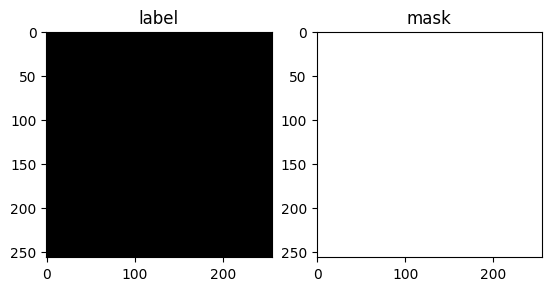

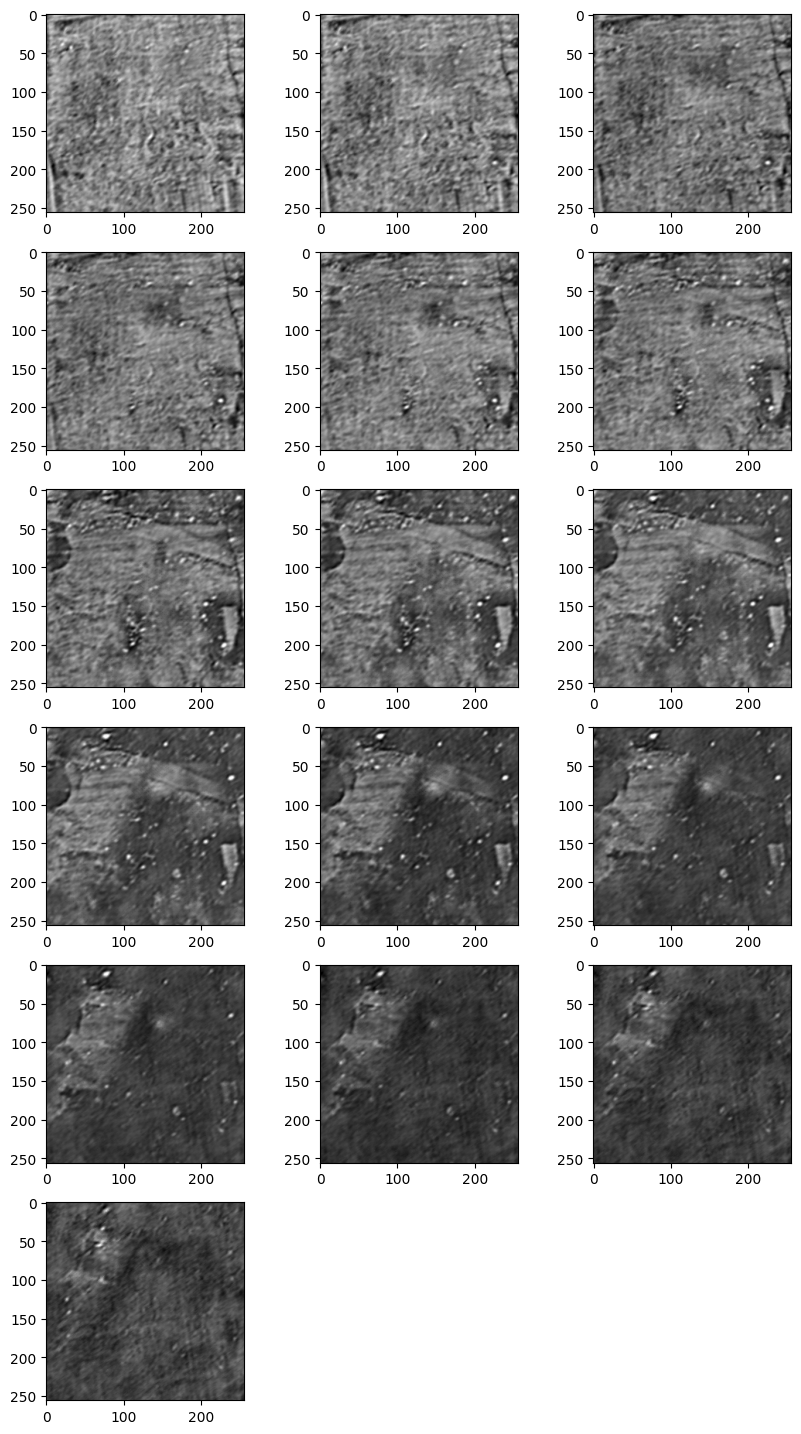

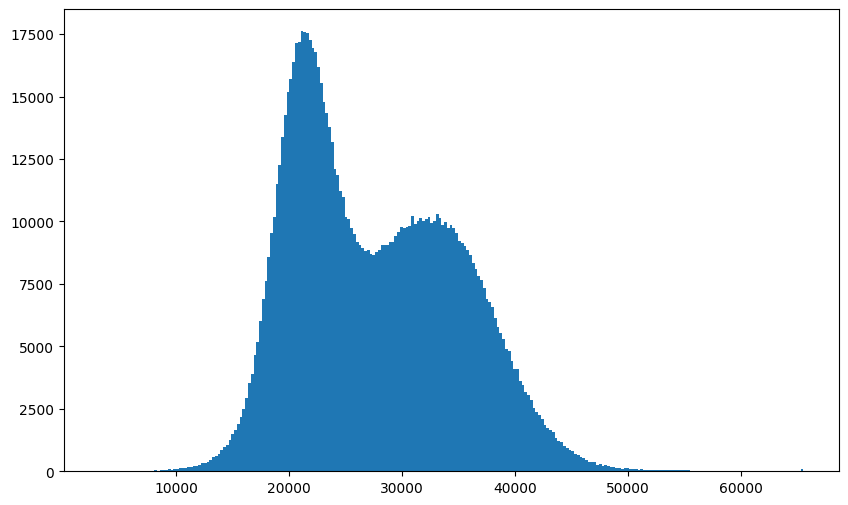

In [5]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


### Model

In [6]:
class SmpUnetDecoder(nn.Module):
    def __init__(self,
                 in_channel,
                 skip_channel,
                 out_channel,
                 ):
        super().__init__()
        self.center = nn.Identity()

        i_channel = [in_channel,] + out_channel[:-1]
        s_channel = skip_channel
        o_channel = out_channel
        block = [
            DecoderBlock(i, s, o, use_batchnorm=True, attention_type=None)
            for i, s, o in zip(i_channel, s_channel, o_channel)
        ]
        self.block = nn.ModuleList(block)

    def forward(self, feature, skip):
        d = self.center(feature)
        decode = []
        for i, block in enumerate(self.block):
            s = skip[i]
            d = block(d, s)
            decode.append(d)

        last = d
        return last, decode


class Net(nn.Module):
    def __init__(self,):
        super().__init__()
        self.output_type = ['inference', 'loss']

        conv_dim = 64
        encoder1_dim = [conv_dim, 64, 128, 256, 512, ]
        decoder1_dim = [256, 128, 64, 64,]

        self.encoder1 = resnet34d(pretrained=True, in_chans=CFG.crop_depth)

        self.decoder1 = SmpUnetDecoder(
            in_channel=encoder1_dim[-1],
            skip_channel=encoder1_dim[:-1][::-1],
            out_channel=decoder1_dim,
        )
        # -- pool attention weight
        self.weight1 = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            ) for dim in encoder1_dim
        ])
        self.logit1 = nn.Conv2d(decoder1_dim[-1], 1, kernel_size=1)

        # --------------------------------
        #
        encoder2_dim = [256, 512, 1024, 2048]
        decoder2_dim = [512, 256, 128, ]
        self.encoder2 = resnet14t(pretrained=True, in_chans=decoder1_dim[-1])

        self.decoder2 = SmpUnetDecoder(
            in_channel=encoder2_dim[-1],
            skip_channel=encoder2_dim[:-1][::-1],
            out_channel=decoder2_dim,
        )
        self.logit2 = nn.Conv2d(decoder2_dim[-1], 1, kernel_size=1)

    def forward(self, batch):
        v = batch
        B, C, H, W = v.shape
        random_shift = random.randint(0, CFG.random_shift)
        vv = [
            v[:, i+random_shift:i+random_shift+CFG.crop_depth] for i in CFG.layer_shift
        ]
        K = len(vv)
        x = torch.cat(vv, 0)
        # x = v

        # ----------------------
        encoder = []
        e = self.encoder1
        x = e.conv1(x)
        x = e.bn1(x)
        x = e.act1(x)
        encoder.append(x)
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        x = e.layer1(x)
        encoder.append(x)
        x = e.layer2(x)
        encoder.append(x)
        x = e.layer3(x)
        encoder.append(x)
        x = e.layer4(x)
        encoder.append(x)
        # print('encoder', [f.shape for f in encoder])

        for i in range(len(encoder)):
            e = encoder[i]
            f = self.weight1[i](e)
            _, c, h, w = e.shape
            f = rearrange(f, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
            e = rearrange(e, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
            w = F.softmax(f, 1)
            e = (w * e).sum(1)
            encoder[i] = e

        feature = encoder[-1]
        skip = encoder[:-1][::-1]
        last, decoder = self.decoder1(feature, skip)
        logit1 = self.logit1(last)

        # ----------------------
        x = last  # .detach()
        # x = F.avg_pool2d(x,kernel_size=2,stride=2)
        encoder = []
        e = self.encoder2
        x = e.layer1(x)
        encoder.append(x)
        x = e.layer2(x)
        encoder.append(x)
        x = e.layer3(x)
        encoder.append(x)
        x = e.layer4(x)
        encoder.append(x)

        feature = encoder[-1]
        skip = encoder[:-1][::-1]
        last, decoder = self.decoder2(feature, skip)
        logit2 = self.logit2(last)
        logit1 = F.interpolate(logit1, size=(H, W), mode='bilinear', align_corners=False, antialias=True)
        logit2 = F.interpolate(logit2, size=(H, W), mode='bilinear', align_corners=False, antialias=True)

        return logit1, logit2


### Training

In [12]:
for fold_i, fold in enumerate(glob(f"{CFG.train_dataset_path}/*")):
    if fold_i<=2:continue
    fold = os.path.basename(fold).split(".")[0]
    valid_fragment_i = int(fold.split("_")[0])
    valid_split_i = int(fold.split("_")[1])
    print(f"fold: {fold_i}")

    train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess, "inklabels")

    dataloader_train, dataloader_valid = generate_dataloader(train_images, train_labels,  valid_images, valid_labels, valid_xyxys, CFG)

    n_train = len(dataloader_train)
    n_valid = len(dataloader_valid)

    gt_mask = generate_valid_label(valid_fragment_i, valid_split_i, CFG, "inklabels")
    gt_shape = gt_mask.shape


    num_gpus = torch.cuda.device_count()
    device_ids = list(range(num_gpus))

    model = Net()
    model = nn.DataParallel(model, device_ids=device_ids)
    model = model.cuda()

    scaler = amp.GradScaler()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
    scheduler = get_scheduler(CFG, optimizer)

    fbeta = 0

    for epoch in range(CFG.epochs):
        model.train()
        cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        pbar_train = enumerate(dataloader_train)
        pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        mloss_train, mloss_val = 0.0, 0.0

        for i, (fragments, masks) in pbar_train:
            fragments, masks = fragments.cuda(), masks.cuda()
            optimizer.zero_grad()
            with amp.autocast():  # type: ignore
                logit1, logit2 = model(fragments)
                loss1 = criterion(logit1, masks)
                loss2 = criterion(logit2, masks)
                loss = loss1+loss2
                scaler.scale(loss).backward()# type: ignore
                scaler.step(optimizer)
                scaler.update()
                mloss_train += loss.detach().item()

            gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
            pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, cur_lr,
                                                                  f"Loss: {mloss_train / (i + 1):.4f}"))

        scheduler.step()
        model.eval()
        pbar_val = enumerate(dataloader_valid)
        pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')  # type: ignore
        final_pred_count = torch.zeros(gt_shape)

        for i, (fragments, masks, xys) in pbar_val:
            fragments, masks = fragments.cuda(), masks.cuda()
            with torch.no_grad():
                logit1, logit2 = model(fragments)
                loss1 = criterion(logit1, masks)
                loss2 = criterion(logit2, masks)
                loss = loss1+loss2
                mloss_val += loss.detach().item()
                pred_masks = torch.sigmoid(logit2)

            for j, xy in enumerate(xys):
                final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] += pred_masks[j, 0]
                final_pred_count[xy[1]:xy[3], xy[0]:xy[2]] += np.ones((CFG.size, CFG.size))

            pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
        final_pred_mask = final_pred_mask.cpu()
        final_pred_mask /= final_pred_count

        fbeta_ = fbeta_score(final_pred_mask, gt_mask, 0.5)
        print(f"FBeta : {fbeta_:.4f}\tSAVED MODEL\n" if fbeta_ > fbeta else f"FBeta : {fbeta_:.4f}\n")
        if fbeta_ > fbeta:
            fbeta = fbeta_
            model_path = f'./{CFG.exp_name}/{CFG.exp_name}_fold{fold_i}.pth'
            torch.save({'model': model.module.state_dict(),
                        'preds': final_pred_mask.numpy()},
                       model_path)

    del model
    gc.collect()
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify


fold: 3


Epoch 0/30  Mem : 15.4GB  LR : 1.00E-04  Loss: 0.8284: 100%|██████████| 354/354 [03:20<00:00,  1.76it/s]
Val Loss: 0.7450: 100%|██████████| 92/92 [00:18<00:00,  5.00it/s]


FBeta : 0.3297	SAVED MODEL



Epoch 1/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.5072: 100%|██████████| 354/354 [03:21<00:00,  1.76it/s]
Val Loss: 0.7467: 100%|██████████| 92/92 [00:18<00:00,  5.09it/s]


FBeta : 0.0044



Epoch 2/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.4485: 100%|██████████| 354/354 [03:20<00:00,  1.77it/s]
Val Loss: 0.7017: 100%|██████████| 92/92 [00:18<00:00,  5.00it/s]


FBeta : 0.4191	SAVED MODEL



Epoch 3/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.4210: 100%|██████████| 354/354 [03:17<00:00,  1.79it/s]
Val Loss: 0.6228: 100%|██████████| 92/92 [00:17<00:00,  5.13it/s]


FBeta : 0.3404



Epoch 4/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.4052: 100%|██████████| 354/354 [03:15<00:00,  1.81it/s]
Val Loss: 0.5762: 100%|██████████| 92/92 [00:17<00:00,  5.15it/s]


FBeta : 0.5685	SAVED MODEL



Epoch 5/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3942: 100%|██████████| 354/354 [03:15<00:00,  1.81it/s]
Val Loss: 0.6584: 100%|██████████| 92/92 [00:17<00:00,  5.16it/s]


FBeta : 0.2645



Epoch 6/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3845: 100%|██████████| 354/354 [03:15<00:00,  1.81it/s]
Val Loss: 0.5942: 100%|██████████| 92/92 [00:17<00:00,  5.15it/s]


FBeta : 0.4643



Epoch 7/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3742: 100%|██████████| 354/354 [03:16<00:00,  1.80it/s]
Val Loss: 0.5531: 100%|██████████| 92/92 [00:17<00:00,  5.12it/s]


FBeta : 0.6321	SAVED MODEL



Epoch 8/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3674: 100%|██████████| 354/354 [03:23<00:00,  1.74it/s]
Val Loss: 0.6501: 100%|██████████| 92/92 [00:18<00:00,  5.01it/s]


FBeta : 0.3516



Epoch 9/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3579: 100%|██████████| 354/354 [03:25<00:00,  1.72it/s]
Val Loss: 0.5880: 100%|██████████| 92/92 [00:18<00:00,  4.93it/s]


FBeta : 0.5959



Epoch 10/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3472: 100%|██████████| 354/354 [03:20<00:00,  1.77it/s]
Val Loss: 0.5250: 100%|██████████| 92/92 [00:18<00:00,  5.10it/s]


FBeta : 0.6667	SAVED MODEL



Epoch 11/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3409: 100%|██████████| 354/354 [03:19<00:00,  1.77it/s]
Val Loss: 0.5262: 100%|██████████| 92/92 [00:18<00:00,  5.11it/s]


FBeta : 0.6751	SAVED MODEL



Epoch 12/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3301: 100%|██████████| 354/354 [03:17<00:00,  1.79it/s]
Val Loss: 0.5224: 100%|██████████| 92/92 [00:18<00:00,  5.09it/s]


FBeta : 0.6578



Epoch 13/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3222: 100%|██████████| 354/354 [03:17<00:00,  1.79it/s]
Val Loss: 0.5069: 100%|██████████| 92/92 [00:18<00:00,  5.09it/s]


FBeta : 0.6708



Epoch 14/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3192: 100%|██████████| 354/354 [03:16<00:00,  1.80it/s]
Val Loss: 0.6171: 100%|██████████| 92/92 [00:17<00:00,  5.15it/s]


FBeta : 0.5822



Epoch 15/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3106: 100%|██████████| 354/354 [03:15<00:00,  1.81it/s]
Val Loss: 0.5245: 100%|██████████| 92/92 [00:17<00:00,  5.12it/s]


FBeta : 0.6698



Epoch 16/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3009: 100%|██████████| 354/354 [03:15<00:00,  1.81it/s]
Val Loss: 0.5423: 100%|██████████| 92/92 [00:17<00:00,  5.14it/s]


FBeta : 0.6462



Epoch 17/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2958: 100%|██████████| 354/354 [03:15<00:00,  1.81it/s]
Val Loss: 0.5171: 100%|██████████| 92/92 [00:17<00:00,  5.13it/s]


FBeta : 0.6876	SAVED MODEL



Epoch 18/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2880: 100%|██████████| 354/354 [03:15<00:00,  1.81it/s]
Val Loss: 0.5129: 100%|██████████| 92/92 [00:17<00:00,  5.14it/s]


FBeta : 0.6539



Epoch 19/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2772: 100%|██████████| 354/354 [03:15<00:00,  1.81it/s]
Val Loss: 0.5796: 100%|██████████| 92/92 [00:17<00:00,  5.16it/s]


FBeta : 0.6424



Epoch 20/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2715: 100%|██████████| 354/354 [03:15<00:00,  1.81it/s]
Val Loss: 0.5136: 100%|██████████| 92/92 [00:17<00:00,  5.12it/s]


FBeta : 0.6740



Epoch 21/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2663: 100%|██████████| 354/354 [03:15<00:00,  1.81it/s]
Val Loss: 0.5990: 100%|██████████| 92/92 [00:17<00:00,  5.16it/s]


FBeta : 0.6453



Epoch 22/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2615: 100%|██████████| 354/354 [03:15<00:00,  1.81it/s]
Val Loss: 0.5582: 100%|██████████| 92/92 [00:17<00:00,  5.16it/s]


FBeta : 0.6675



Epoch 23/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2512: 100%|██████████| 354/354 [03:15<00:00,  1.81it/s]
Val Loss: 0.5282: 100%|██████████| 92/92 [00:17<00:00,  5.15it/s]


FBeta : 0.6738



Epoch 24/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2464: 100%|██████████| 354/354 [03:16<00:00,  1.80it/s]
Val Loss: 0.5331: 100%|██████████| 92/92 [00:17<00:00,  5.12it/s]


FBeta : 0.7080	SAVED MODEL



Epoch 25/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2410: 100%|██████████| 354/354 [03:20<00:00,  1.76it/s]
Val Loss: 0.5618: 100%|██████████| 92/92 [00:18<00:00,  5.05it/s]


FBeta : 0.6961



Epoch 26/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2325: 100%|██████████| 354/354 [03:16<00:00,  1.80it/s]
Val Loss: 0.5202: 100%|██████████| 92/92 [00:17<00:00,  5.16it/s]


FBeta : 0.7112	SAVED MODEL



Epoch 27/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2307: 100%|██████████| 354/354 [03:20<00:00,  1.77it/s]
Val Loss: 0.5409: 100%|██████████| 92/92 [00:18<00:00,  5.04it/s]


FBeta : 0.7075



Epoch 28/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2280: 100%|██████████| 354/354 [03:20<00:00,  1.77it/s]
Val Loss: 0.5365: 100%|██████████| 92/92 [00:18<00:00,  5.04it/s]


FBeta : 0.6889



Epoch 29/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2247: 100%|██████████| 354/354 [03:17<00:00,  1.79it/s]
Val Loss: 0.5578: 100%|██████████| 92/92 [00:17<00:00,  5.15it/s]


FBeta : 0.7014

fold: 4


Epoch 0/30  Mem : 15.4GB  LR : 1.00E-04  Loss: 0.7456: 100%|██████████| 370/370 [03:29<00:00,  1.77it/s]
Val Loss: 0.5104: 100%|██████████| 76/76 [00:14<00:00,  5.09it/s]


FBeta : 0.3042	SAVED MODEL



Epoch 1/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.5401: 100%|██████████| 370/370 [03:26<00:00,  1.79it/s]
Val Loss: 0.4398: 100%|██████████| 76/76 [00:15<00:00,  5.06it/s]


FBeta : 0.4133	SAVED MODEL



Epoch 2/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.4899: 100%|██████████| 370/370 [03:26<00:00,  1.79it/s]
Val Loss: 0.3786: 100%|██████████| 76/76 [00:14<00:00,  5.10it/s]


FBeta : 0.4517	SAVED MODEL



Epoch 3/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.4604: 100%|██████████| 370/370 [03:27<00:00,  1.79it/s]
Val Loss: 0.3987: 100%|██████████| 76/76 [00:15<00:00,  5.00it/s]


FBeta : 0.5133	SAVED MODEL



Epoch 4/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.4439: 100%|██████████| 370/370 [03:30<00:00,  1.76it/s]
Val Loss: 0.4206: 100%|██████████| 76/76 [00:15<00:00,  5.00it/s]


FBeta : 0.4974



Epoch 5/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.4256: 100%|██████████| 370/370 [03:29<00:00,  1.76it/s]
Val Loss: 0.3453: 100%|██████████| 76/76 [00:15<00:00,  5.03it/s]


FBeta : 0.5964	SAVED MODEL



Epoch 6/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.4149: 100%|██████████| 370/370 [03:29<00:00,  1.77it/s]
Val Loss: 0.3648: 100%|██████████| 76/76 [00:14<00:00,  5.12it/s]


FBeta : 0.5628



Epoch 7/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.4070: 100%|██████████| 370/370 [03:24<00:00,  1.81it/s]
Val Loss: 0.3395: 100%|██████████| 76/76 [00:14<00:00,  5.14it/s]


FBeta : 0.5624



Epoch 8/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3973: 100%|██████████| 370/370 [03:24<00:00,  1.81it/s]
Val Loss: 0.3337: 100%|██████████| 76/76 [00:14<00:00,  5.15it/s]


FBeta : 0.6225	SAVED MODEL



Epoch 9/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3897: 100%|██████████| 370/370 [03:24<00:00,  1.81it/s]
Val Loss: 0.3648: 100%|██████████| 76/76 [00:14<00:00,  5.14it/s]


FBeta : 0.5651



Epoch 10/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3781: 100%|██████████| 370/370 [03:24<00:00,  1.81it/s]
Val Loss: 0.4135: 100%|██████████| 76/76 [00:14<00:00,  5.14it/s]


FBeta : 0.4747



Epoch 11/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3687: 100%|██████████| 370/370 [03:24<00:00,  1.81it/s]
Val Loss: 0.3493: 100%|██████████| 76/76 [00:14<00:00,  5.11it/s]


FBeta : 0.5798



Epoch 12/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3616: 100%|██████████| 370/370 [03:25<00:00,  1.80it/s]
Val Loss: 0.3364: 100%|██████████| 76/76 [00:15<00:00,  5.04it/s]


FBeta : 0.6216



Epoch 13/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3546: 100%|██████████| 370/370 [03:28<00:00,  1.78it/s]
Val Loss: 0.3507: 100%|██████████| 76/76 [00:14<00:00,  5.08it/s]


FBeta : 0.5814



Epoch 14/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3465: 100%|██████████| 370/370 [03:29<00:00,  1.77it/s]
Val Loss: 0.3316: 100%|██████████| 76/76 [00:15<00:00,  5.02it/s]


FBeta : 0.6208



Epoch 15/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3333: 100%|██████████| 370/370 [03:30<00:00,  1.76it/s]
Val Loss: 0.3231: 100%|██████████| 76/76 [00:14<00:00,  5.16it/s]


FBeta : 0.6295	SAVED MODEL



Epoch 16/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3242: 100%|██████████| 370/370 [03:30<00:00,  1.76it/s]
Val Loss: 0.3276: 100%|██████████| 76/76 [00:15<00:00,  4.97it/s]


FBeta : 0.6318	SAVED MODEL



Epoch 17/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3164: 100%|██████████| 370/370 [03:26<00:00,  1.79it/s]
Val Loss: 0.3415: 100%|██████████| 76/76 [00:14<00:00,  5.11it/s]


FBeta : 0.6350	SAVED MODEL



Epoch 18/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.3093: 100%|██████████| 370/370 [03:24<00:00,  1.81it/s]
Val Loss: 0.3298: 100%|██████████| 76/76 [00:14<00:00,  5.11it/s]


FBeta : 0.6454	SAVED MODEL



Epoch 19/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2939: 100%|██████████| 370/370 [03:24<00:00,  1.81it/s]
Val Loss: 0.3298: 100%|██████████| 76/76 [00:14<00:00,  5.14it/s]


FBeta : 0.6378



Epoch 20/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2915: 100%|██████████| 370/370 [03:24<00:00,  1.81it/s]
Val Loss: 0.3344: 100%|██████████| 76/76 [00:14<00:00,  5.12it/s]


FBeta : 0.6304



Epoch 21/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2803: 100%|██████████| 370/370 [03:24<00:00,  1.81it/s]
Val Loss: 0.3361: 100%|██████████| 76/76 [00:14<00:00,  5.10it/s]


FBeta : 0.6455	SAVED MODEL



Epoch 22/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2727: 100%|██████████| 370/370 [03:24<00:00,  1.81it/s]
Val Loss: 0.3595: 100%|██████████| 76/76 [00:14<00:00,  5.12it/s]


FBeta : 0.5737



Epoch 23/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2643: 100%|██████████| 370/370 [03:24<00:00,  1.81it/s]
Val Loss: 0.3841: 100%|██████████| 76/76 [00:14<00:00,  5.11it/s]


FBeta : 0.5444



Epoch 24/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2564: 100%|██████████| 370/370 [03:24<00:00,  1.81it/s]
Val Loss: 0.3213: 100%|██████████| 76/76 [00:14<00:00,  5.09it/s]


FBeta : 0.6516	SAVED MODEL



Epoch 25/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2484: 100%|██████████| 370/370 [03:24<00:00,  1.81it/s]
Val Loss: 0.3344: 100%|██████████| 76/76 [00:14<00:00,  5.14it/s]


FBeta : 0.6505



Epoch 26/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2450: 100%|██████████| 370/370 [03:24<00:00,  1.81it/s]
Val Loss: 0.3415: 100%|██████████| 76/76 [00:14<00:00,  5.10it/s]


FBeta : 0.6144



Epoch 27/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2381: 100%|██████████| 370/370 [03:24<00:00,  1.81it/s]
Val Loss: 0.3351: 100%|██████████| 76/76 [00:14<00:00,  5.14it/s]


FBeta : 0.6437



Epoch 28/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2335: 100%|██████████| 370/370 [03:24<00:00,  1.81it/s]
Val Loss: 0.3375: 100%|██████████| 76/76 [00:14<00:00,  5.16it/s]


FBeta : 0.6319



Epoch 29/30  Mem : 15.4GB  LR : 1.00E-03  Loss: 0.2318: 100%|██████████| 370/370 [03:24<00:00,  1.81it/s]
Val Loss: 0.3340: 100%|██████████| 76/76 [00:14<00:00,  5.16it/s]


FBeta : 0.6401

{"status":200,"message":"ok"}

In [13]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)

fbeta: 0.6227
fbeta: 0.6297
fbeta: 0.6831
fbeta: 0.7112
fbeta: 0.6516


In [14]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.6595


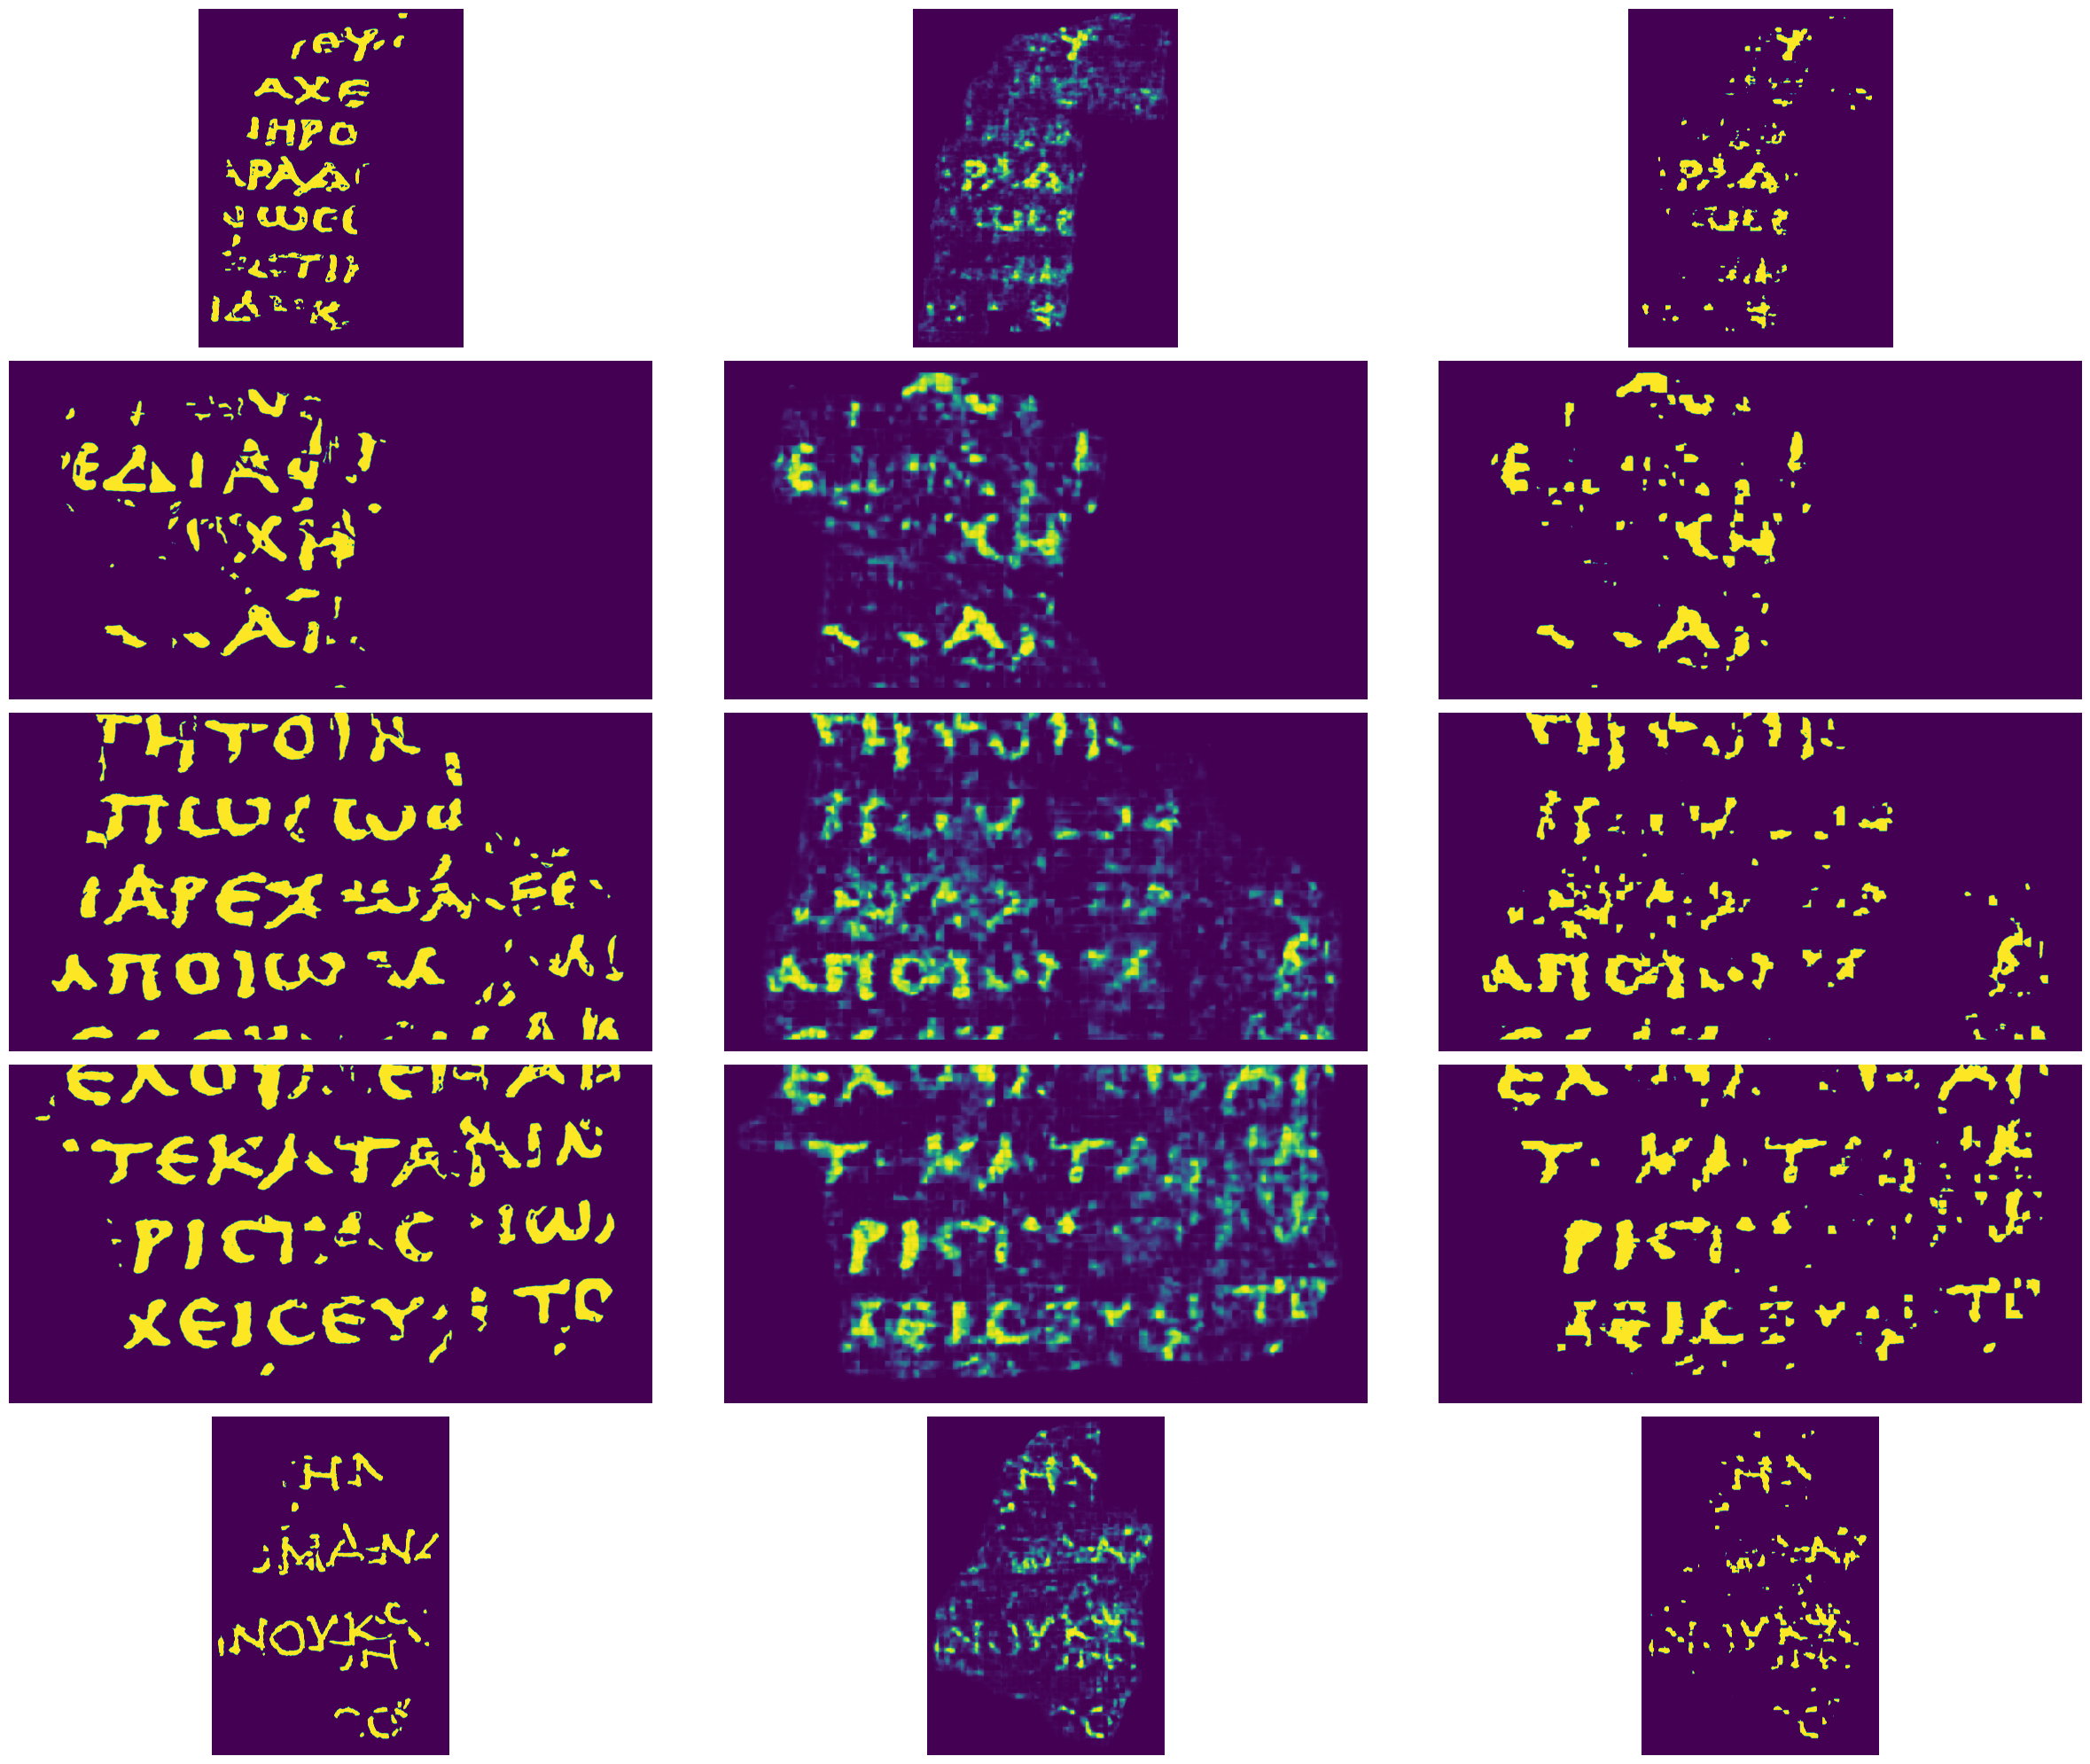

In [15]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)